In [1]:
import os
from typing import Dict, List, Tuple
import json
from datetime import datetime
import warnings
warnings.simplefilter("ignore")
import numpy as np
import fire

import torch
from torch import Tensor
import torch.nn as nn

import sklearn.gaussian_process as gp

from bayesian_optimization import BayesianOptimization
#from utils.bo_utils import BatchedDIPProblem

from train_utils import get_net_and_optim
from super_resolution import super_resolution
from denoising import denoising
from inpainting import inpainting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 11
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
exp_name = "bo_inp"
trials = 10
num_iter_eval_fn = 1
batch_size = 3
num_iter_gp = 10
n_init = 4
criterion = 'nll'
metric = "psnr_gt_sm"
img_name = "skin_lesion0"
task = 'inpainting'
config = "./configs/bo_prior_sigma"
log_dir = "../bo_exps"
trials_log_dir = None
gpus = [0]
seed = 11

In [3]:
torch.manual_seed(seed)
np.random.seed(seed)

with open(config + ".json") as f:
    config = json.load(f)

if log_dir is not None:
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    log_dir = f"{log_dir}/{exp_name}"
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)

# TODO: make that also False when None for path_log_dir in fns
save_trials = False if trials_log_dir is None else True
batch_size = len(gpus) if batch_size is None else batch_size

In [4]:
class BatchedDIPProblem(nn.Module):

    def __init__(self,
                 task: str,
                 config: Dict,
                 metric: str = "psnr_gt",
                 img_name: str = "xray",
                 criterion: str = 'nll',
                 num_iter_eval_fn: int = 10000,
                 save_trials: bool = False,
                 path_log_dir: str = ".",
                 gpus: List[int] = [0, 1],
                 seed: int = None):

        super(BatchedDIPProblem, self).__init__()

        if task == "denoising":
            self.fn = denoising
            self.net_structure = json.load(open("./configs/net_den.json"))
        elif task == "super_resolution":
            self.fn = super_resolution
            self.net_structure = json.load(open("./configs/net_sr.json"))
        elif task == "inpainting":
            self.fn = inpainting
            self.net_structure = json.load(open("./configs/net_inp.json"))

        self.net_params = config["net_params"]
        self.optim_params = config["optim_params"]
        self.net_specs = config["net_specs"]
        self.optim_specs = config["optim_specs"]
        self.metric = metric
        self.criterion=criterion
        self.seed = seed

        self.params = [p["name"] for p in config["parameter"]]

        self.img_name = img_name
        self.num_iter_eval_fn = num_iter_eval_fn
        self.save_trials = save_trials
        self.path_log_dir = path_log_dir
        self.gpus = gpus

        #try:
        #    mp.set_start_method('spawn')
        #except RuntimeError:
        #    print("spawn method has already been set")

    def mp_fn(self,
              gpu: int,
              single_params: Tensor,
              results: Tensor,
              order: int):

        device = 'cuda:' + str(gpu)
        net_specs = self.net_specs.copy()
        optim_specs = self.optim_specs.copy()

        for i, param in enumerate(self.params):
            if param in self.optim_params:
                optim_specs[param] = float(single_params[i])
            else:
                net_specs[param] = float(single_params[i])

        net, optimizer = get_net_and_optim(net_specs=net_specs, optim_specs=optim_specs, **self.net_structure)

        single_result = self.fn(img_name=self.img_name,
                                num_iter=self.num_iter_eval_fn,
                                criterion=self.criterion,
                                net_specs=net_specs,
                                optim_specs=optim_specs,
                                save=self.save_trials,
                                path_log_dir=self.path_log_dir,
                                gpu=gpu,
                                net=net,
                                optimizer=optimizer,
                                seed=self.seed)

        res = single_result[self.metric] # [-int(0.1*self.num_iter_eval_fn):]
        results[order] = torch.tensor([np.max(res)]) # ([np.mean(res)])

        results = results[torch.where(results != 0.)[0]]

    def forward(self, params: Tensor) -> Tensor:
        results = torch.zeros(len(params))
        processes = []
        _gpus = (self.gpus * np.ceil(len(params)/len(self.gpus)).astype('int'))[:len(params)]
        for order, (single_params, gpu) in enumerate(zip(params, _gpus)):
            print(f"Starting process {order+1}/{len(params)}...")
            self.mp_fn(gpus[0], single_params, results, order)
            #p = mp.Process(target=self.mp_fn, args=(gpu, single_params, results, order,))
            #p.start()
            #processes.append(p)
        #print('Waiting for processes to finish')
        #for p in processes:
        #    p.join()

        return results

In [5]:
params = {p["name"]: p["bounds"] for p in config["parameter"]}
lengthscale_prior = config["lengthscale_prior"] if "lengthscale_prior" in list(config.keys()) else dict(concentration=0.3, rate=1.)
lengthscale_constraint = config["lengthscale_constraint"] if "lengthscale_constraint" in list(config.keys()) else 0.05

mean_prior = config["mean_prior"] if "mean_prior" in list(config.keys()) else dict(loc=12., scale=2.)
noise_prior = config["noise_prior"] if "noise_prior" in list(config.keys()) else dict(concentration=1e-2, rate=100.)


initial_params_vals = config["initial_parameter"] if "initial_parameter" in config.keys() else None

acq_kwargs = {"xi": 0.1}

In [6]:
batched_dip_prob = BatchedDIPProblem(
    path_log_dir=trials_log_dir, gpus=gpus, task=task, config=config,
    num_iter_eval_fn=num_iter_eval_fn, save_trials=save_trials,
    img_name=img_name, metric=metric, seed=None
)

bayesian_optimization = BayesianOptimization(
    params=params,
    initial_params_vals=initial_params_vals,
    n_init=n_init,
    obj_fn=batched_dip_prob,
    acq_fn='expected_improvement',
    acq_kwargs=acq_kwargs
)

Starting process 1/4...


I: 1 | ELBO: 3.19 | PSNR_noisy: 14.63 | PSNR_gt: 11.35 | PSNR_gt_sm: 11.35: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Starting process 2/4...


I: 1 | ELBO: 2.95 | PSNR_noisy: 13.10 | PSNR_gt: 11.09 | PSNR_gt_sm: 11.09: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Starting process 3/4...


I: 1 | ELBO: 4.14 | PSNR_noisy: 14.64 | PSNR_gt: 11.37 | PSNR_gt_sm: 11.37: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Starting process 4/4...


I: 1 | ELBO: 4.62 | PSNR_noisy: 14.50 | PSNR_gt: 11.51 | PSNR_gt_sm: 11.51: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Training GP...
loss: 61.505 | lengthscale: 0.050 | noise: 0.31147: 100%|██████████| 10/10 [00:00<00:00, 20.65it/s]
Starting process 1/2...


I: 1 | ELBO: 2.44 | PSNR_noisy: 13.81 | PSNR_gt: 11.19 | PSNR_gt_sm: 11.19: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Starting process 2/2...


I: 1 | ELBO: 4.68 | PSNR_noisy: 15.21 | PSNR_gt: 10.95 | PSNR_gt_sm: 10.95: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


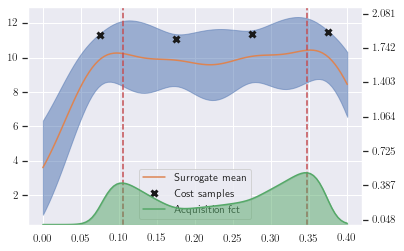

Training GP...
loss: 41.526 | lengthscale: 0.050 | noise: 0.31353: 100%|██████████| 10/10 [00:00<00:00, 86.52it/s]
Starting process 1/2...


I: 1 | ELBO: 4.87 | PSNR_noisy: 12.79 | PSNR_gt: 10.99 | PSNR_gt_sm: 10.99: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
  0%|          | 0/1 [00:00<?, ?it/s]

Starting process 2/2...


  0%|          | 0/1 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [7]:
best_params = bayesian_optimization.optimize(
    trials=trials, plot=True, gpu=gpus[0], path=log_dir,
    lengthscale_prior=lengthscale_prior, mean_prior=mean_prior,
    noise_prior=noise_prior, lengthscale_constraint=lengthscale_constraint,
    num_iter_gp=num_iter_gp, batch_size=batch_size
)

print(best_params)